# Introduction

This project is going to look for EEG biomarkers of alcoholism. The main goal of this project is try and predict whether a person is an alcholic or not based on features obtained from the EEG data we have. 

The EEG Database on UCI website contains 64-channel electroencephalography (EEG) data from 121 alcoholic and control subjects participating in a visual event-related potential (ERP) experiment.

Subjects were exposed to three experimental conditions:

(1)obj single visual stimulus
(2)match two matching visual stimuli
(3)nonmatch two non-matching visual stimuli.

Each subject participated in multiple trials (replications) of each experimental condition. Data were recorded at 256 Hz for 1 second following the presentation of the visual stimulus/stimuli.


The main goal of this project is try and predict whether a person is an alcholic based on various features obtained from the EEG data we have. 



## Read in Data

The data has already been pre-processed. You can get all the raw files here: https://drive.google.com/drive/folders/1QEsxcAWYLakE35Dt2I4dcxgTatYMuG_D?usp=sharing. Below you will find the script to read in the 122 data files and combine them all together from the `eeg_folder` folder on your computer. 


In [2]:
import os             # File management
import pandas as pd     # Data frame manipulation
import numpy as np      # Data frame operations
import glob
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
import dask as dd # read in 
from dask import dataframe as dd
import vaex


In [7]:

path= '/Users/jgeller1/Desktop/ERDOS_EEG_Project3/egg_data' # this will be different and needs to be changed on own computer

all_files = glob.glob(os.path.join(path, "*.csv")) # join path and append .csv to end

all_files

len(all_files)

121

# Concatenate 

Here we are going to concatenate all the csv files together. In order to speed up reading all these files in we are going to use the `vaex` package. It is incredibly efficent for reading in all the files. 

In [8]:
%%time
df_concat = vaex.open_many(all_files)


#concat_df=(pd.concat(pd.read_csv(f) for f in all_files))




CPU times: user 2min 15s, sys: 15.8 s, total: 2min 31s
Wall time: 2min 32s


In [ ]:
With `vaex` it takes us 2min and 15s to process all the files. 

In [9]:
df_concat.head()

#,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value
0,0,0,'co3c0000402',2,False,'obj',False,'FP1',0,0.732
1,1,1,'co3c0000402',2,False,'obj',False,'FP1',1,2.686
2,2,2,'co3c0000402',2,False,'obj',False,'FP1',2,5.127
3,3,3,'co3c0000402',2,False,'obj',False,'FP1',3,7.568
4,4,4,'co3c0000402',2,False,'obj',False,'FP1',4,9.033
5,5,5,'co3c0000402',2,False,'obj',False,'FP1',5,9.521
6,6,6,'co3c0000402',2,False,'obj',False,'FP1',6,9.521
7,7,7,'co3c0000402',2,False,'obj',False,'FP1',7,9.033
8,8,8,'co3c0000402',2,False,'obj',False,'FP1',8,9.033
9,9,9,'co3c0000402',2,False,'obj',False,'FP1',9,9.521


The df_concat object has several columns: 

    - `subject`: Subject number
    - `trail`: Trial number
    - `alcholic`: True (alcholic) False not
    - `match`: Condition (match, nonmatch, obj)
    - `err`: 
    - `sensor`: senor locations (one of 64)
    - `sample`: Time
    - `value` : Voltage (uV)
    

Due to computational issues, we subset our data to only look at one electrode(Cz) and then we will aggregate across time and trials. 


In [10]:
df_Cz = df_concat[df_concat.sensor.isin(["CZ"])] # select Cz channel 

In [27]:
df_Cz.export_csv('no_cz_trials.csv') # let's save this as a csv

In [29]:
cz_df=pd.read_csv('no_cz_trials.csv')

cz_df

,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value
0,3840,3840.0,co3c0000402,2,False,obj,False,CZ,0,8.219
1,3841,3841.0,co3c0000402,2,False,obj,False,CZ,1,8.219
2,3842,3842.0,co3c0000402,2,False,obj,False,CZ,2,7.731
3,3843,3843.0,co3c0000402,2,False,obj,False,CZ,3,7.243
4,3844,3844.0,co3c0000402,2,False,obj,False,CZ,4,7.243
...,...,...,...,...,...,...,...,...,...,...
2804219,1576955,NaN,co2a0000403,119,True,match,False,CZ,251,-28.168
2804220,1576956,NaN,co2a0000403,119,True,match,False,CZ,252,-28.168
2804221,1576957,NaN,co2a0000403,119,True,match,False,CZ,253,-29.633
2804222,1576958,NaN,co2a0000403,119,True,match,False,CZ,254,-32.562


Let's look at the amplitude differences between alcholics and controls across each of three conditions

Let's change the sampling rate so it is in milliseconds and not some abritrary number. 

In [102]:
cz_df["sample"] = pd.to_numeric(cz_df["sample"], downcast="float")

cz_df['Time'] = cz_df[['sample']]*3.91 # change to ms

cz_df['subject'] = cz_df['subject'].astype(str)

cz_df['match'] = cz_df['match'].astype(str)


cz_df

,Unnamed: 0,Unnamed: 0.1,subject,trial,alcoholic,match,err,sensor,sample,value,Time
0,3840,3840.0,co3c0000402,2,False,obj,False,CZ,0.0,8.219,0.000000
1,3841,3841.0,co3c0000402,2,False,obj,False,CZ,1.0,8.219,3.910000
2,3842,3842.0,co3c0000402,2,False,obj,False,CZ,2.0,7.731,7.820000
3,3843,3843.0,co3c0000402,2,False,obj,False,CZ,3.0,7.243,11.730000
4,3844,3844.0,co3c0000402,2,False,obj,False,CZ,4.0,7.243,15.640000
...,...,...,...,...,...,...,...,...,...,...,...
2804219,1576955,NaN,co2a0000403,119,True,match,False,CZ,251.0,-28.168,981.410034
2804220,1576956,NaN,co2a0000403,119,True,match,False,CZ,252.0,-28.168,985.320007
2804221,1576957,NaN,co2a0000403,119,True,match,False,CZ,253.0,-29.633,989.230042
2804222,1576958,NaN,co2a0000403,119,True,match,False,CZ,254.0,-32.562,993.140015


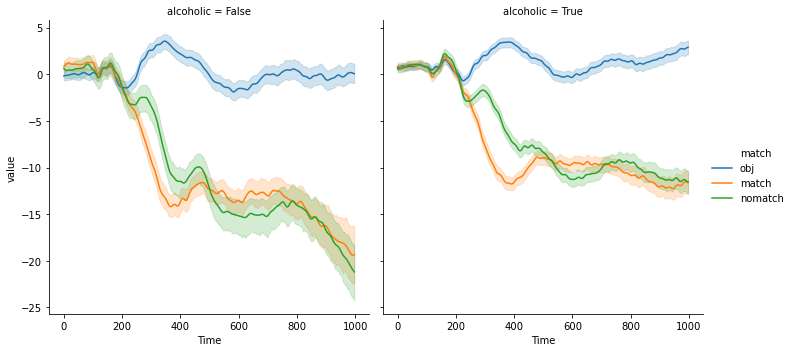

In [110]:

ax=sns.relplot(x="Time", y="value", kind="line", hue="match", col="alcoholic", data=cz_df)


plt.show()


In [ ]:
Let's look at the amplitude differences between alcholics and controls aggregated across condition and retun some 

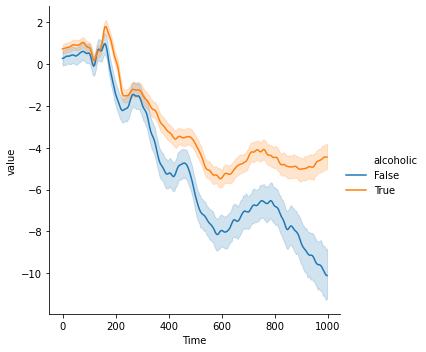

In [85]:
ax=sns.relplot(x="Time", y="value", kind="line", hue="alcoholic", data=cz_df)


plt.show()

Now that our data is a bit smaller let's use pandas to work with the data. 

# Features

There are a number of features one could look at with this type of data. Here I am going to extract a few features I think our important.




## Mean amplitude for each condition by subject

To do this we will group by subject, match, sample, and alcholic category. We will create a wide DF to add to a bigger feature csv file. 

In [117]:

df1_agg = cz_df.groupby(['subject', 'match', 'alcoholic'])['value'].mean()


df1_agg.head()

subject      match    alcoholic
co2a0000364  match    True        -15.778111
             nomatch  True        -14.104428
             obj      True          5.108323
co2a0000365  match    True         -8.428477
             nomatch  True         -8.517720
Name: value, dtype: float64

In [118]:
df1_agg.to_csv('no_trials.csv') # let's save this as a csv

In [119]:
no_trials=pd.read_csv('no_trials.csv')

no_trials

,subject,match,alcoholic,value
0,co2a0000364,match,True,-15.778111
1,co2a0000364,nomatch,True,-14.104428
2,co2a0000364,obj,True,5.108323
3,co2a0000365,match,True,-8.428477
4,co2a0000365,nomatch,True,-8.517720
...,...,...,...,...
358,co3a0000461,nomatch,True,-3.504227
359,co3a0000461,obj,True,-0.739263
360,co3c0000402,match,False,-13.558304
361,co3c0000402,nomatch,False,-12.589800


## P300


A classic neurophysiological marker is the P300 which is a positive amplitude beween 250 ms and 550 ms. Lets get the mean amplitude between those times to use as features

In [124]:

df_p300= cz_df[(cz_df['Time'] >= 250) & (cz_df['Time'] <=550)]


df_p300_df=df_p300.groupby(["subject", "alcoholic", "match"]).value.mean()

# write file to csv
df_p300_df

df_p300_df.to_csv("df_p300", sep='\t', encoding='utf-8')

#groupby('subject').value.mean()

# Overall mean for the match, nomatch, and Obj trials

In [126]:
df_p300_df=df_p300.groupby(["subject", "alcoholic", "match"]).value.mean()

In [128]:
df_p300_df

subject      alcoholic  match  
co2a0000364  True       match     -14.191272
                        nomatch    -9.451732
                        obj         9.249465
co2a0000365  True       match     -10.046991
                        nomatch    -6.466113
                                     ...    
co3a0000461  True       nomatch    -2.253674
                        obj         3.265270
co3c0000402  False      match     -14.373963
                        nomatch   -12.694069
                        obj         2.948908
Name: value, Length: 363, dtype: float64